# Library

In [1]:
from tqdm.notebook import tqdm
import time

In [2]:
from vmdpy import VMD
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from numpy.fft import rfft, irfft, rfftfreq
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import  TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torchinfo import summary

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# Data

In [4]:
path_fault2_ex = 'C:/Users/baek/Desktop/NURO/data_cycle/abnormal2/external'
path_fault2_in = 'C:/Users/baek/Desktop/NURO/data_cycle/abnormal2/internal'

path_fault1_ex = 'C:/Users/baek/Desktop/NURO/data_cycle/abnormal1/external'
path_fault1_in = 'C:/Users/baek/Desktop/NURO/data_cycle/abnormal1/internal'

path_normal_ex = 'C:/Users/baek/Desktop/NURO/data_cycle/normal/external'
path_normal_in = 'C:/Users/baek/Desktop/NURO/data_cycle/normal/internal'

In [5]:
dat_f1 = [[] for i in range(0,2)]
dat_f2 = [[] for i in range(0,2)]
dat_n = []

In [6]:
for i in range(len(os.listdir(path_fault1_ex))):
    temp =pd.read_csv(path_fault1_ex + '/'+ os.listdir(path_fault1_ex)[i], sep = '\t' )
    dat_f1[0].append(temp)
    
    
for i in range(len(os.listdir(path_fault1_in))):
    temp = pd.read_csv(path_fault1_in + '/'+os.listdir(path_fault1_in)[i], sep = ',' , low_memory=False)
    dat_f1[1].append(temp)

    
for i in range(len(os.listdir(path_fault2_ex))):
    temp =pd.read_csv(path_fault2_ex + '/'+ os.listdir(path_fault2_ex)[i], sep = '\t' )
    dat_f2[0].append(temp)
    
    
for i in range(len(os.listdir(path_fault2_in))):
    temp = pd.read_csv(path_fault2_in + '/'+os.listdir(path_fault2_in)[i], sep = ',' , low_memory=False)
    dat_f2[1].append(temp)
    
    
for i in range(len(os.listdir(path_normal_ex))):
    temp =pd.read_csv(path_normal_ex + '/'+os.listdir(path_normal_ex)[i], sep = '\t' )
    dat_n.append(temp)

In [7]:
data_f1_Torque = []
data_f2_Torque = []
data_n_Torque = []


for i in range(len(dat_f1[1])):
    data_n_Torque.append(dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(1),['ActualTorque']].reset_index().drop(labels = 'index', axis=1))


for i in range(len(dat_f1[1])):
    data_f1_Torque.append(dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),['ActualTorque']].reset_index().drop(labels = 'index', axis=1))

    
for i in range(len(dat_f2[1])):
    data_f2_Torque.append(dat_f2[1][i].loc[dat_f2[1][i]['CoreSN'] == 'core0'+str(2),['ActualTorque']].reset_index().drop(labels = 'index', axis=1))
    

# data_f1_Torque = []
# data_f2_Torque = []
# data_n_Torque = []

# for i in range(len(dat_f1[1])):
#     temp = dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(1),'ActualTorque'].reset_index().drop(labels = 'index', axis=1) 
#     scaler_ = MinMaxScaler()
#     scaler_.fit(temp)
#     data_n_Torque.append(pd.DataFrame(scaler_.transform(temp)))


# for i in range(len(dat_f1[1])):
#     temp = dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),'ActualTorque'].reset_index().drop(labels = 'index', axis=1) 
#     scaler_ = MinMaxScaler()
#     scaler_.fit(temp)
#     data_f1_Torque.append(pd.DataFrame(scaler_.transform(temp)))

# for i in range(len(dat_f2[1])):
#     temp = dat_f2[1][i].loc[dat_f2[1][i]['CoreSN'] == 'core0'+str(2),'ActualTorque'].reset_index().drop(labels = 'index', axis=1) 
#     scaler_ = MinMaxScaler()
#     scaler_.fit(temp)
#     data_f2_Torque.append(pd.DataFrame(scaler_.transform(temp)))

    


data_f1_Acc = []
for i in range(len(dat_f1[0])):
    dat_f1[0][i].loc[:,['ax(g)']] = dat_f1[0][i].loc[:,['ax(g)']] - dat_f1[0][i].loc[:,['ax(g)']].rolling(500).mean().fillna(0)
    dat_f1[0][i].loc[:,['ay(g)']] = dat_f1[0][i].loc[:,['ay(g)']] - dat_f1[0][i].loc[:,['ay(g)']].rolling(500).mean().fillna(0)
    dat_f1[0][i].loc[:,['az(g)']] = dat_f1[0][i].loc[:,['az(g)']] - dat_f1[0][i].loc[:,['az(g)']].rolling(500).mean().fillna(0)
    temp = dat_f1[0][i].loc[np.unique(np.around(np.array([i for i in range(len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]))]) / len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]) * len(dat_f1[0][i])).astype('int')).tolist()].reset_index().drop(labels = ['index'], axis=1)
    temp = temp.loc[:,['ax(g)','ay(g)','az(g)']]
    scaler_ = MinMaxScaler()
    scaler_.fit(temp)
    data_f1_Acc.append(pd.DataFrame(scaler_.transform(temp)))    
 #   temp = dat_f1[0][i].loc[np.unique(np.around(np.array([i for i in range(len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]))]) / len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]) * len(dat_f1[0][i])).astype('int')).tolist()].reset_index().drop(labels = ['index'], axis=1)

data_f2_Acc = []
for i in range(len(dat_f2[0])):
    dat_f2[0][i].loc[:,['ax(g)']]  = dat_f2[0][i].loc[:,['ax(g)']] - dat_f2[0][i].loc[:,['ax(g)']].rolling(500).mean().fillna(0)
    dat_f2[0][i].loc[:,['ay(g)']] = dat_f2[0][i].loc[:,['ay(g)']] - dat_f2[0][i].loc[:,['ay(g)']].rolling(500).mean().fillna(0)
    dat_f2[0][i].loc[:,['az(g)']] = dat_f2[0][i].loc[:,['az(g)']] - dat_f2[0][i].loc[:,['az(g)']].rolling(500).mean().fillna(0)
    temp = dat_f2[0][i].loc[np.unique(np.around(np.array([i for i in range(len(dat_f2[1][i].loc[dat_f2[1][i]['CoreSN'] == 'core0'+str(2),:]))]) / len(dat_f2[1][i].loc[dat_f2[1][i]['CoreSN'] == 'core0'+str(2),:]) * len(dat_f2[0][i])).astype('int')).tolist()].reset_index().drop(labels = ['index'], axis=1)
    temp = temp.loc[:,['ax(g)','ay(g)','az(g)']]
    scaler_ = MinMaxScaler()
    scaler_.fit(temp)
    data_f2_Acc.append(pd.DataFrame(scaler_.transform(temp)))    
 #   temp = dat_f1[0][i].loc[np.unique(np.around(np.array([i for i in range(len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]))]) / len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]) * len(dat_f1[0][i])).astype('int')).tolist()].reset_index().drop(labels = ['index'], axis=1)


data_n_Acc = []
for i in range(len(dat_n)):
    dat_n[i].loc[:,['ax(g)']] = dat_n[i].loc[:,['ax(g)']] - dat_n[i].loc[:,['ax(g)']].rolling(500).mean().fillna(0)
    dat_n[i].loc[:,['ay(g)']] = dat_n[i].loc[:,['ay(g)']] - dat_n[i].loc[:,['ay(g)']].rolling(500).mean().fillna(0)
    dat_n[i].loc[:,['az(g)']] = dat_n[i].loc[:,['az(g)']] - dat_n[i].loc[:,['az(g)']].rolling(500).mean().fillna(0)
    temp = dat_n[i].loc[np.unique(np.around(np.array([i for i in range(len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(1),:]))]) / len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(1),:]) * len(dat_n[i])).astype('int')).tolist()].reset_index().drop(labels = ['index'], axis=1)
    temp = temp.loc[:,['ax(g)','ay(g)','az(g)']]
    scaler_ = MinMaxScaler()
    scaler_.fit(temp)
    data_n_Acc.append(pd.DataFrame(scaler_.transform(temp)))    
 #   temp = dat_f1[0][i].loc[np.unique(np.around(np.array([i for i in range(len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]))]) / len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]) * len(dat_f1[0][i])).astype('int')).tolist()].reset_index().drop(labels = ['index'], axis=1)

##temp = temp.loc[np.unique(np.around(np.array([i for i in range(min_data_len)]) / min_data_len * len(temp)).astype('int')).tolist()].reset_index()
    
    
# data_f1_Acc = []
# for i in range(len(dat_f1[0])):
#     temp = dat_f1[0][i].loc[:,['ax(g)','ay(g)','az(g)']] - dat_f1[0][i].loc[:,['ax(g)','ay(g)','az(g)']].median()
#     temp = temp.loc[np.unique(np.around(np.array([i for i in range(len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]))]) / len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:]) * len(temp)).astype('int')).tolist()].reset_index().drop(labels = ['index'], axis=1)
#     data_f1_Acc.append(temp)
    
# data_f2_Acc = []
# for i in range(len(dat_f2[0])):
#     temp = dat_f2[0][i].loc[:,['ax(g)','ay(g)','az(g)']] - dat_f2[0][i].loc[:,['ax(g)','ay(g)','az(g)']].median()
#     temp = temp.loc[np.unique(np.around(np.array([i for i in range(len(dat_f2[1][i].loc[dat_f2[1][i]['CoreSN'] == 'core0'+str(2),:]))]) / len(dat_f2[1][i].loc[dat_f2[1][i]['CoreSN'] == 'core0'+str(2),:]) * len(temp)).astype('int')).tolist()].reset_index().drop(labels = ['index'], axis=1)
#     data_f2_Acc.append(temp)
    
# data_n_Acc = []
# for i in range(len(dat_n)):
#     temp = dat_n[i].loc[:,['ax(g)','ay(g)','az(g)']] - dat_n[i].loc[:,['ax(g)','ay(g)','az(g)']].median()
#     temp = temp.loc[np.unique(np.around(np.array([i for i in range(len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(1),:]))]) / len( dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(1),:]) * len(temp)).astype('int')).tolist()].reset_index().drop(labels = ['index'], axis=1)
#     data_n_Acc.append(temp)

# VMD

In [8]:

#. some sample parameters for VMD  
alpha = 2000       # moderate bandwidth constraint  
tau = 0.            # noise-tolerance (no strict fidelity enforcement)          # 3 modes  
DC = 0             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-7

In [9]:
d_n = []
d_f1 = []
d_f2 = []


for i in tqdm(range(len(data_n_Torque))):
    temp, u_hat, omega = VMD((data_n_Torque[i].loc[:,'ActualTorque']).to_numpy(), alpha, tau, 4, DC, init, tol)
    d_n.append(temp)
    
    
for i in tqdm(range(len(data_f1_Torque))):
    temp, u_hat, omega = VMD((data_f1_Torque[i].loc[:,'ActualTorque']).to_numpy(), alpha, tau, 4, DC, init, tol)
    d_f1.append(temp)
    
for i in tqdm(range(len(data_f2_Torque))):
    temp, u_hat, omega = VMD((data_f2_Torque[i].loc[:,'ActualTorque']).to_numpy(), alpha, tau, 4, DC, init, tol)
    d_f2.append(temp)

# d_n = []
# d_f1 = []
# d_f2 = []


# for i in tqdm(range(len(data_n))):
#     temp, u_hat, omega = VMD((data_n_Torque[i].loc[:,'ActualTorque']).to_numpy(), alpha, tau, 4, DC, init, tol)
#     d_n.append(temp)
    
    
# for i in tqdm(range(len(data_f1))):
#     temp, u_hat, omega = VMD((data_f1_Torque[i].loc[:,'ActualTorque']).to_numpy(), alpha, tau, 4, DC, init, tol)
#     d_f1.append(temp)
    
# for i in tqdm(range(len(data_f2))):
#     temp, u_hat, omega = VMD((data_f2_Torque[i].loc[:,'ActualTorque']).to_numpy(), alpha, tau, 4, DC, init, tol)
#     d_f2.append(temp)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

# VMD Data Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


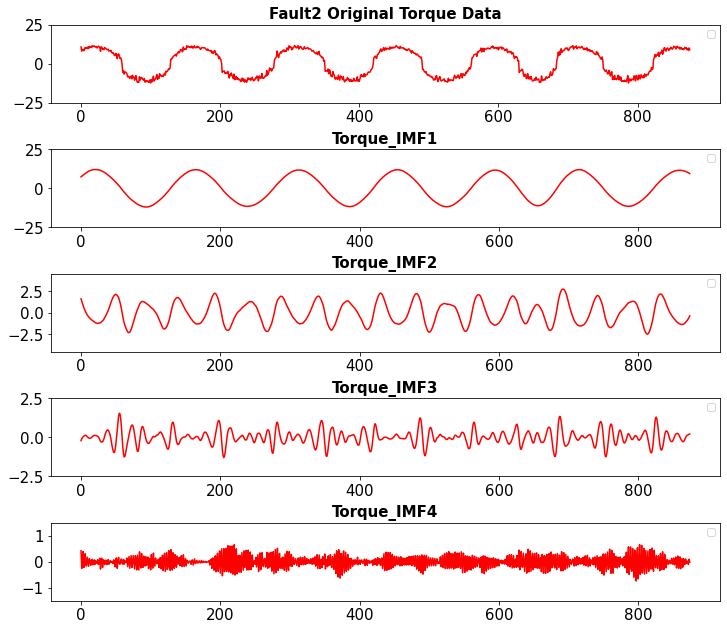

In [52]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.6)

plt.subplot(5,1 , 1) 

plt.plot(data_f2_Torque[2].loc[125:1000,'ActualTorque'].reset_index().drop(columns = ['index']),'r')

plt.title('Fault2 Original Torque Data', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-25, 25)

plt.subplot(5,1 , 2) 

plt.plot(pd.DataFrame(d_f2[2]).transpose().iloc[125:1000,0:1].reset_index().drop(columns = ['index']),'r')

plt.title('Torque_IMF1', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-25, 25)
plt.subplot(5,1 , 3) 

plt.plot(pd.DataFrame(d_f2[2]).transpose().iloc[125:1000,1:2].reset_index().drop(columns = ['index']),'r')

plt.title('Torque_IMF2', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-4.5, 4.5)

plt.subplot(5,1 , 4) 

plt.plot(pd.DataFrame(d_f2[2]).transpose().iloc[125:1000,2:3].reset_index().drop(columns = ['index']),'r')

plt.title('Torque_IMF3', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-2.5, 2.5)


plt.subplot(5,1 , 5) 

plt.plot(pd.DataFrame(d_f2[2]).transpose().iloc[125:1000,3:4].reset_index().drop(columns = ['index']),'r')

plt.title('Torque_IMF4', fontdict=title_font)
plt.legend()

title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-1.5, 1.5)


plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


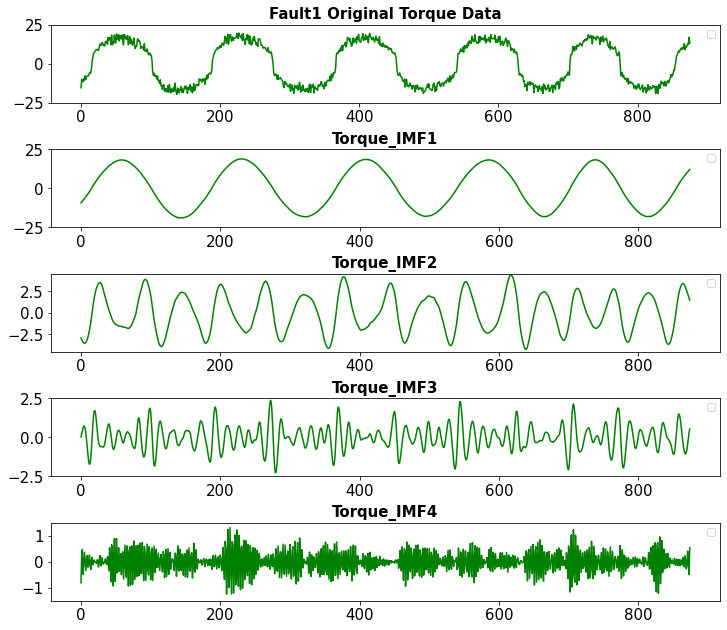

In [50]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.6)

plt.subplot(5,1 , 1) 

plt.plot(data_f1_Torque[2].loc[125:1000,'ActualTorque'].reset_index().drop(columns = ['index']),'g')

plt.title('Fault1 Original Torque Data', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-25, 25)

plt.subplot(5,1 , 2) 

plt.plot(pd.DataFrame(d_f1[2]).transpose().iloc[125:1000,0:1].reset_index().drop(columns = ['index']),'g')

plt.title('Torque_IMF1', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-25, 25)
plt.subplot(5,1 , 3) 

plt.plot(pd.DataFrame(d_f1[2]).transpose().iloc[125:1000,1:2].reset_index().drop(columns = ['index']),'g')

plt.title('Torque_IMF2', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-4.5, 4.5)

plt.subplot(5,1 , 4) 

plt.plot(pd.DataFrame(d_f1[2]).transpose().iloc[125:1000,2:3].reset_index().drop(columns = ['index']),'g')

plt.title('Torque_IMF3', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-2.5, 2.5)

plt.subplot(5,1 , 5) 

plt.plot(pd.DataFrame(d_f1[2]).transpose().iloc[125:1000,3:4].reset_index().drop(columns = ['index']),'g')

plt.title('Torque_IMF4', fontdict=title_font)
plt.legend()

title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-1.5, 1.5)


plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


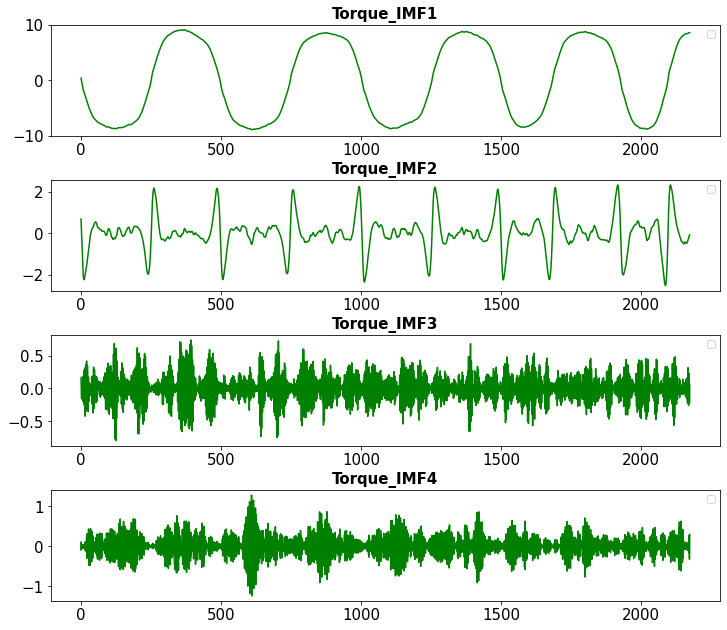

In [19]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
plt.subplot(4,1 , 1) 

plt.plot(pd.DataFrame(d_n[0]).transpose().iloc[125:2300,0:1].reset_index().drop(columns = ['index']),'g')
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.title('Torque_IMF1', fontdict=title_font)
plt.legend()

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-10, 10)
plt.subplot(4,1 , 2) 

plt.plot(pd.DataFrame(d_n[0]).transpose().iloc[125:2300,1:2].reset_index().drop(columns = ['index']),'g')

plt.title('Torque_IMF2', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.subplot(4,1 , 3) 

plt.plot(pd.DataFrame(d_n[0]).transpose().iloc[125:2300,2:3].reset_index().drop(columns = ['index']),'g')

plt.title('Torque_IMF3', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.subplot(4,1 , 4) 

plt.plot(pd.DataFrame(d_n[0]).transpose().iloc[125:2300,3:4].reset_index().drop(columns = ['index']),'g')

plt.title('Torque_IMF4', fontdict=title_font)
plt.legend()

title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


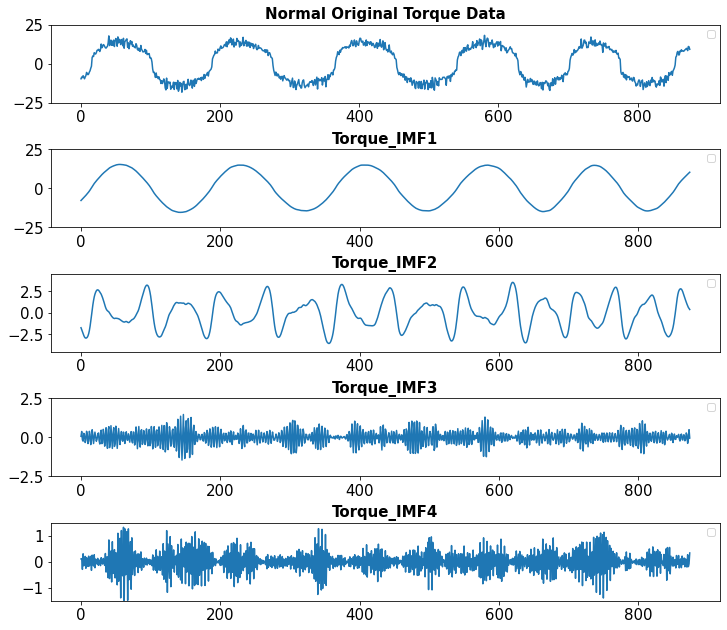

In [51]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.6)

plt.subplot(5,1 , 1) 

plt.plot(data_n_Torque[2].loc[125:1000,'ActualTorque'].reset_index().drop(columns = ['index']))

plt.title('Normal Original Torque Data', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-25, 25)

plt.subplot(5,1 , 2) 

plt.plot(pd.DataFrame(d_n[2]).transpose().iloc[125:1000,0:1].reset_index().drop(columns = ['index']))

plt.title('Torque_IMF1', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-25, 25)
plt.subplot(5,1 , 3) 

plt.plot(pd.DataFrame(d_n[2]).transpose().iloc[125:1000,1:2].reset_index().drop(columns = ['index']))

plt.title('Torque_IMF2', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-4.5, 4.5)
plt.subplot(5,1 , 4) 

plt.plot(pd.DataFrame(d_n[2]).transpose().iloc[125:1000,2:3].reset_index().drop(columns = ['index']))

plt.title('Torque_IMF3', fontdict=title_font)
plt.legend()
title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-2.5, 2.5)
plt.subplot(5,1 , 5) 

plt.plot(pd.DataFrame(d_n[2]).transpose().iloc[125:1000,3:4].reset_index().drop(columns = ['index']))

plt.title('Torque_IMF4', fontdict=title_font)
plt.legend()

title_font = {
            'fontsize' : 15,
            'fontweight' : 'bold'
        }
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.ylim(-1.5, 1.5)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


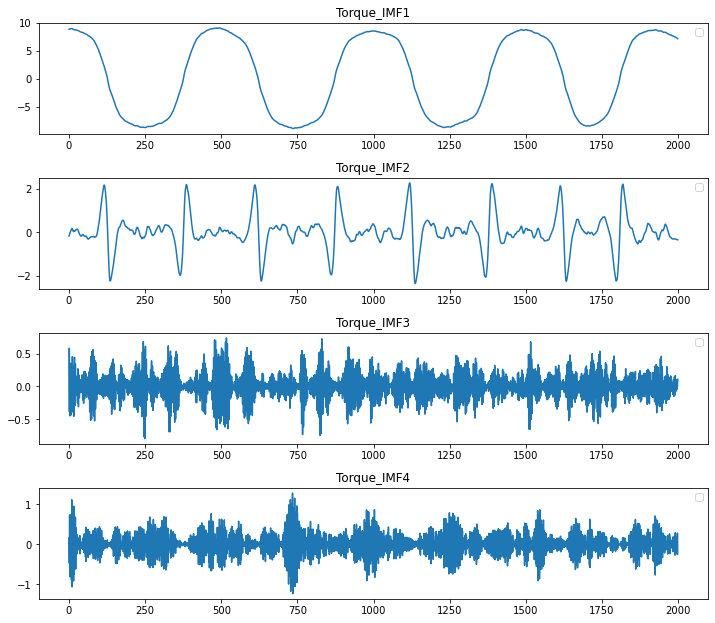

In [278]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
plt.subplot(4,1 , 1) 

plt.plot(pd.DataFrame(d_n[0]).transpose().iloc[0:2000,0:1])

plt.title('Torque_IMF1')
plt.legend()

plt.subplot(4,1 , 2) 

plt.plot(pd.DataFrame(d_n[0]).transpose().iloc[0:2000,1:2])

plt.title('Torque_IMF2')
plt.legend()
plt.subplot(4,1 , 3) 

plt.plot(pd.DataFrame(d_n[0]).transpose().iloc[0:2000,2:3])

plt.title('Torque_IMF3')
plt.legend()
plt.subplot(4,1 , 4) 

plt.plot(pd.DataFrame(d_n[0]).transpose().iloc[0:2000,3:4])

plt.title('Torque_IMF4')
plt.legend()

# Train Data 

In [170]:
data_f1_Torq_vmd = []
data_f2_Torq_vmd = []
data_n_Torq_vmd = []

for i in range(len(d_n)):
    temp = d_n[i][1:4]
    scaler_ = MinMaxScaler()
    scaler_.fit(temp)
    data_n_Torq_vmd.append(pd.DataFrame(temp).transpose())
    
for i in range(len(d_f1)):
    temp = d_f1[i][1:4]
    scaler_ = MinMaxScaler()
    scaler_.fit(temp)
    data_f1_Torq_vmd.append(pd.DataFrame(temp).transpose())

for i in range(len(d_f2)):
    temp = d_f2[i][1:4]
    scaler_ = MinMaxScaler()
    scaler_.fit(temp)
    data_f2_Torq_vmd.append(pd.DataFrame(temp).transpose())

In [178]:
data_f1= []
data_f2 = []
data_n = []

for i in range(9):
    data_f1.append(pd.concat((data_f1_Torq_vmd[i],data_f1_Acc[i]), axis = 1))
    

for i in range(9):
    data_f2.append(pd.concat((data_f2_Torq_vmd[i],data_f2_Acc[i]), axis = 1))
    

for i in range(9):
    data_n.append(pd.concat((data_n_Torq_vmd[i],data_n_Acc[i]), axis = 1))

In [183]:
dd_n =  [ [] for i in range(9)]
dd_f1 =  [ [] for i in range(9)]
dd_f2 = [ [] for i in range(9)]


for i in range(0,9):
    for j in range(len(data_n[i].iloc[:-1,:])//511):
        dd_n[i].append(data_n[i].loc[511*j:511*(j+1),:])

for i in range(0,9):
    for j in range(len(data_f1[i].iloc[:-1,:])//511):
        dd_f1[i].append(data_f1[i].loc[511*j:511*(j+1),:])
        
for i in range(0,9):
    for j in range(len(data_f2[i].iloc[:-1,:])//511):
        dd_f2[i].append(data_f2[i].loc[511*j:511*(j+1),:])


In [315]:
# dd_n =  [ [] for i in range(9)]
# dd_f1 =  [ [] for i in range(9)]
# dd_f2 = [ [] for i in range(9)]


# for i in range(0,9):
#     temp = pd.DataFrame(d_n[i]).transpose()
#     for j in range(len(d_n[i][0])//511):
#         dd_n[i].append(temp.loc[511*j:511*(j+1),:])

# for i in range(0,9):
#     temp = pd.DataFrame(d_f1[i]).transpose()
#     for j in range(len(d_f1[i][0])//511):
#         dd_f1[i].append(temp.loc[511*j:511*(j+1),:])
        
# for i in range(0,9):
#     temp = pd.DataFrame(d_f2[i]).transpose()
#     for j in range(len(d_f2[i][0])//511):
#         dd_f2[i].append(temp.loc[511*j:511*(j+1),:])


In [184]:

normal= dd_n[0]
for i in range(1,5):
    normal.extend(dd_n[i])
    
    
fault1 = dd_f1[0]
for i in range(1,5):
    fault1.extend(dd_f1[i])

fault2 = dd_f2[0]
for i in range(1,5):
    fault2.extend(dd_f2[i])
    
    
    

In [186]:
label_n = [0 for i in range(len(normal))]
label_f1 = [1 for i in range(len(fault1))]
label_f2 = [2 for i in range(len(fault2))]


In [187]:
normal.extend(fault1)
label_n.extend(label_f1)

normal.extend(fault2)
label_n.extend(label_f2)

In [188]:
X_train, X_valid, y_train, y_valid = train_test_split(normal,label_n,test_size=0.2, random_state=42)

for i in range(len(X_train)):
    X_train[i] = np.array(X_train[i])
    
for i in range(len(X_valid)):
    X_valid[i] = np.array(X_valid[i])
    
X_valid = np.array(X_valid)
X_train = np.array(X_train)
y_valid = np.array(y_valid)
y_train = np.array(y_train)

X_valid = X_valid.reshape(len(X_valid),6,512)
X_train = X_train.reshape(len(X_train),6,512)


In [399]:
# X_train = torch.FloatTensor(X_train)
# X_valid = torch.FloatTensor(X_valid)

# X_train = X_train.view([-1, 3,32, 32])
# X_valid = X_valid.view([-1, 3,32, 32])

# y_train = torch.LongTensor(y_train)
# y_valid = torch.LongTensor(y_valid)

In [189]:
X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)

X_train = X_train.view([-1,6, 512])
X_valid = X_valid.view([-1,6, 512])

y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [190]:
Train = TensorDataset(X_train,y_train)
Valid = TensorDataset(X_valid, y_valid)



Train_loader = DataLoader(Train, batch_size=32, shuffle=True)
Valid_loader = DataLoader(Valid, batch_size=32, shuffle=True)

# Model

In [191]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(6,32,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(32,64,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(64,64,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(64,128,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(128,128,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv1d(128,256,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(256,256,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
    
        self.fc1 = nn.Linear(8192,2000, bias = True)
        self.fc2 = nn.Linear(2000,500, bias = True)
        self.fc3 = nn.Linear(500,100, bias = True)
        self.fc4 = nn.Linear(100,3, bias = True)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
#Convolution - Batch Normalization - Activation - Dropout - Pooling
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = out.view(out.size(0),-1)
        #print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        out = self.fc4(out)
        return out


In [420]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(6,32,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(32,64,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(64,128,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
    
        self.fc1 = nn.Linear(8192,1000, bias = True)
        self.fc2 = nn.Linear(1000,100, bias = True)
        self.fc3 = nn.Linear(100,3, bias = True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
#Convolution - Batch Normalization - Activation - Dropout - Pooling
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = out.view(out.size(0),-1)
        #print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


# Train Model

In [239]:
# instantiate CNN model
model = CNN().to(device)

In [240]:
# parameters
learning_rate = 0.001
training_epochs = 40
batch_size = 32

In [241]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [242]:
# train my model
accuracy_list = []
accuracy_val_list = []
loss_list = []
loss_val_list = []

total_train_batch = len(Train_loader)
total_valid_batch = len(Valid_loader)

print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    avg_acc = 0
    for X, Y in Train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_train_batch
        pred = hypothesis.argmax(dim = 1)
        avg_acc += torch.eq(pred, Y).sum().float().item()
    avg_acc =avg_acc/ 886
    with torch.no_grad():
        avg_val_loss = 0
        val_loss = 0
        avg_val_acc = 0
        for X_val, Y_val in Valid_loader:
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)
            
            y_val_pred = model(X_val)
            val_step_loss = criterion(y_val_pred,Y_val)
            avg_val_loss += val_step_loss / total_valid_batch
            pred_val = y_val_pred.argmax(dim = 1)
            avg_val_acc += torch.eq(pred_val, Y_val).sum().float().item()
        avg_val_acc = avg_val_acc/ 222
    print('[Epoch: {:>4}] train_cost = {:>.9}, valid_cost = {:>.9}'.format(epoch + 1, avg_cost,avg_val_loss))
    print('[Epoch: {:>4}] train_acc = {:>.9}, valid_acc = {:>.9}'.format(epoch + 1, avg_acc, avg_val_acc))
    accuracy_list.append(avg_acc)
    loss_list.append(avg_cost.item())
    accuracy_val_list.append(avg_val_acc)
    loss_val_list.append(avg_val_loss.item())



print('Learning Finished!')


Learning started. It takes sometime.
[Epoch:    1] train_cost = 11.3419123, valid_cost = 3.08321142
[Epoch:    1] train_acc = 0.396162528, valid_acc = 0.536036036
[Epoch:    2] train_cost = 1.96884155, valid_cost = 0.98600781
[Epoch:    2] train_acc = 0.542889391, valid_acc = 0.594594595
[Epoch:    3] train_cost = 1.03521681, valid_cost = 0.782901466
[Epoch:    3] train_acc = 0.584650113, valid_acc = 0.594594595
[Epoch:    4] train_cost = 0.751695812, valid_cost = 0.631542385
[Epoch:    4] train_acc = 0.653498871, valid_acc = 0.734234234
[Epoch:    5] train_cost = 0.647882223, valid_cost = 0.654093742
[Epoch:    5] train_acc = 0.738148984, valid_acc = 0.761261261
[Epoch:    6] train_cost = 0.536211371, valid_cost = 0.589389086
[Epoch:    6] train_acc = 0.756207675, valid_acc = 0.738738739
[Epoch:    7] train_cost = 0.516934872, valid_cost = 0.5159868
[Epoch:    7] train_acc = 0.770880361, valid_acc = 0.774774775
[Epoch:    8] train_cost = 0.432627022, valid_cost = 0.367506325
[Epoch:  

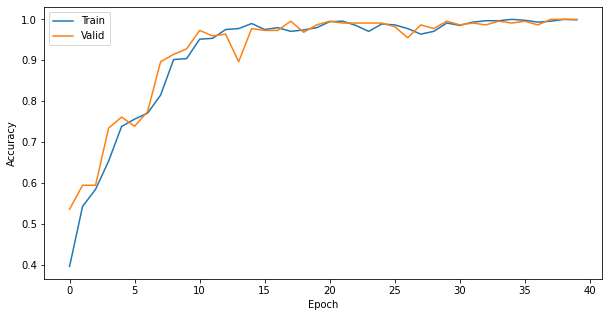

In [243]:
plt.figure(figsize=(10,5))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy_list, label='Train')
plt.plot(accuracy_val_list, label='Valid')

plt.legend()

plt.show()

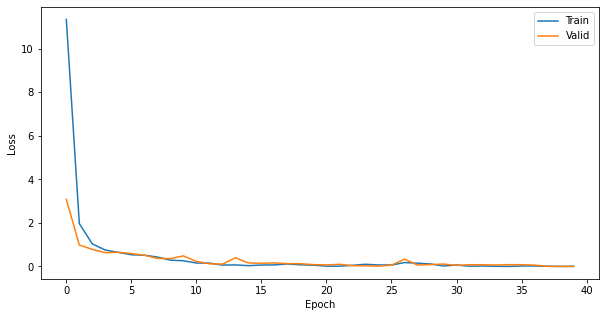

In [246]:
plt.figure(figsize=(10,5))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_list, label='Train')
plt.plot(loss_val_list, label='Valid')

plt.legend()

plt.show()

In [197]:

normal_test= dd_n[5]
for i in range(6,9):
    normal_test.extend(dd_n[i])
    
    
fault1_test = dd_f1[5]
for i in range(6,9):
    fault1_test.extend(dd_f1[i])

fault2_test = dd_f2[5]
for i in range(6,9):
    fault2_test.extend(dd_f2[i])
    
    
    

In [198]:
label_n_test = [0 for i in range(len(normal_test))]
label_f1_test = [1 for i in range(len(fault1_test))]
label_f2_test = [2 for i in range(len(fault2_test))]

normal_test.extend(fault1_test)
label_n_test.extend(label_f1_test)

normal_test.extend(fault2_test)
label_n_test.extend(label_f2_test)

In [199]:
X_test, X_bu, y_test, y_bu = train_test_split(normal_test,label_n_test,test_size=0.1, random_state=42)

for i in range(len(X_test)):
    X_test[i] = np.array(X_test[i])
    
for i in range(len(X_bu)):
    X_bu[i] = np.array(X_bu[i])
    
X_test = np.array(X_test)
X_bu = np.array(X_bu) 
y_bu = np.array(y_bu)
y_test = np.array(y_test)

X_bu = X_bu.reshape(len(X_bu),6,512)
X_test = X_test.reshape(len(X_test),6,512)


In [200]:
X_test = torch.FloatTensor(X_test)
X_test = X_test.view([-1,6, 512])

y_test = torch.LongTensor(y_test)

In [201]:
Test = TensorDataset(X_test, y_test)
Test_loader = DataLoader(Test, batch_size=32, shuffle=True)

In [210]:
len(X_test)

884

# Test Model

In [245]:
total_test_batch = len(Test_loader)
mean_avg = 0
for i in range(50):
 
    with torch.no_grad():
        avg_test_loss = 0
        test_loss = 0
        avg_test_acc = 0
        for X_t, Y_t in Test_loader:
            X_t = X_t.to(device)
            Y_t = Y_t.to(device)

            y_test_pred = model(X_t)
            test_step_loss = criterion(y_test_pred,Y_t)
            avg_test_loss += test_step_loss / total_test_batch
            pred_test = y_test_pred.argmax(dim = 1)
            avg_test_acc += torch.eq(pred_test, Y_t).sum().float().item()
        avg_test_acc = avg_test_acc/ 884
        mean_avg += avg_test_acc
mean_avg/=50

#print('TEST_cost = {:>.9}'.format(avg_test_loss))
print('TEST_acc = {:>.9}'.format( mean_avg))

TEST_acc = 0.979954751


In [248]:
summary(model,input_size = (batch_size, 6,512))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 256]             --
│    └─Conv1d: 2-1                       [32, 32, 512]             608
│    └─BatchNorm1d: 2-2                  [32, 32, 512]             64
│    └─ReLU: 2-3                         [32, 32, 512]             --
│    └─Dropout: 2-4                      [32, 32, 512]             --
│    └─MaxPool1d: 2-5                    [32, 32, 256]             --
├─Sequential: 1-2                        [32, 64, 128]             --
│    └─Conv1d: 2-6                       [32, 64, 256]             6,208
│    └─ReLU: 2-7                         [32, 64, 256]             --
│    └─Conv1d: 2-8                       [32, 64, 256]             12,352
│    └─BatchNorm1d: 2-9                  [32, 64, 256]             128
│    └─ReLU: 2-10                        [32, 64, 256]             --
│    └

In [136]:
# total_test_batch = len(Test_loader)

# with torch.no_grad():
#     avg_test_loss = 0
#     test_loss = 0
#     avg_test_acc = 0
#     for X_test, Y_test in Test_loader:
#         X_test = X_test.to(device)
#         Y_test = Y_test.to(device)

#         y_test_pred = model(X_test)
#         test_step_loss = criterion(y_test_pred,Y_test)
#         avg_test_loss += test_step_loss / total_test_batch
#         pred_test = y_test_pred.argmax(dim = 1)
#         avg_test_acc += torch.eq(pred_test, Y_test).sum().float().item()
#     avg_test_acc = avg_test_acc/ 884
# print('TEST_cost = {:>.9}'.format(avg_test_loss))
# print('TEST_acc = {:>.9}'.format( avg_test_acc))